In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
from scipy import sparse
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
user_seller_matrix = sparse.load_npz('/Volumes/My Passport/user_seller_sparse_matrix.npz')

In [3]:
# SVD, Matrix Factorization
from sklearn.decomposition import NMF
# user_seller_matrix

# S = np.random.rand(10000, 10000)
# for i in tqdm(range(2, 11)):
nmf_model = NMF(n_components=500) 
user_dis = nmf_model.fit_transform(user_seller_matrix)
item_dis = nmf_model.components_
print(user_dis.shape, item_dis.shape)
print(nmf_model.reconstruction_err_)

(963923, 500) (500, 10000)
20959.93668249568


In [6]:
np.save("./data/item_dis.npy", item_dis)
np.save("./data/user_dis.npy", user_dis)

### SVD Features

In [2]:
user_dis = np.load("./data/user_dis.npy")

In [3]:
user_dis.shape

(963923, 500)

In [12]:
user_df = pd.DataFrame(user_dis, columns = ['svd_feature_' + str(i) for i in range(1, 501)])

In [24]:
user_df.to_csv('./data/users_svd_500.csv', index = False)

In [6]:
def heat_map_for_original(X):
    sns.heatmap(X, fmt="d", cmap='YlGnBu')
    plt.show()
def normalization(X):
    min_max_scaler = preprocessing.MinMaxScaler()  
    X_minMax = min_max_scaler.fit_transform(X)
    #print(X[:1, :])
    #print(X_minMax[:1, :])
    return X_minMax
def show_clusters(data, clustering):
    index = []
    values = []
    cluster_maps = defaultdict(int)
    for i in range(len(data)):
        cluster_maps[clustering.labels_[i]] += 1
    for i in cluster_maps:
        index.append(i)
        values.append(cluster_maps[i])
    print(values)
    axes = plt.bar(index, values)
    plt.show()

In [7]:
# normalize
#user_dis_normalized_100_sparse = sparse.csr_matrix(normalization(user_dis[:10000, :100]))
user_dis_normalized = normalization(user_dis[:30000, :1])
del user_dis

In [8]:
user_dis_normalized.shape

(30000, 1)

### Feature Enginneering

users features:
1. (one-hot?) user_id
online:
2. taobao records count: the count of online records of taobao for user u *
3. taobao buy ratio. the ratio between the count of user u bought and clicked. *
4. taobao buy count: the count of records that user u bought in the on-line 
Taobao. *
5. taobao click count: the count of records that user u clicked in the on-line 
Taobao. *
6. items buy count: the number of different items user bought *
7. items click count: the number of different items user viewed *
8. items buy ratio: the ratio between the different items of user u bought and clicked. *
9. categories buy count: the number of different categories user bought *
10. categories click count: the number of different categories user viewed *
11. categories buy ratio: the ratio between the different categories of user u bought and clicked. *
12. categories bought one-hot
13. categories viewed one-hot
14. every category bought count: the number of items user bought in every category
15. every category viewed count: the number of items user bought in every category
onsite:
1. koubei record count *
2. locations shopped count *
3. merchants shopped count *
4. locations of the merchants shopped count

In [2]:
df_tb = pd.read_csv('./data/ijcai2016_taobao.csv')

In [3]:
print(df_tb.shape)
df_tb.head(5)

(44528127, 6)


,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711


In [4]:
new_old_id_maps = pickle.load(open('./data/new_old_id_maps.pkl',"rb"))

In [5]:
user_new_old_id_maps = new_old_id_maps['user_new_old_id_maps']

In [7]:
user_df = pd.DataFrame(list(user_new_old_id_maps.items()), columns = ['new_use_id', 'old_use_id'])

In [8]:
user_df.head(10)

,new_use_id,old_use_id
0,0,1980536
1,1,647747
2,2,183647
3,3,723956
4,4,1781938
5,5,1652831
6,6,416403
7,7,43130
8,8,502518
9,9,109400


In [9]:
tb_buy_count = defaultdict(int)
tb_click_count = defaultdict(int)
tb_buy_items = defaultdict(list)
tb_click_items = defaultdict(list)
tb_buy_cats = defaultdict(list)
tb_click_cats = defaultdict(list)
for i, row in tqdm(df_tb.iterrows()):
    old_use_id = row['use_ID']
    ite_ID = row['ite_ID']
    cat_ID = row['cat_ID']
    if row['act_ID'] == 0:
        tb_click_count[old_use_id] += 1
        if ite_ID not in tb_click_items[old_use_id]:
            tb_click_items[old_use_id].append(ite_ID)
        if cat_ID not in tb_click_cats[old_use_id]:
            tb_click_cats[old_use_id].append(cat_ID)
    else:
        tb_buy_count[old_use_id] += 1
        if ite_ID not in tb_buy_items[old_use_id]:
            tb_buy_items[old_use_id].append(ite_ID)
        if cat_ID not in tb_buy_cats[old_use_id]:
            tb_buy_cats[old_use_id].append(cat_ID)

44528127it [1:07:22, 11015.42it/s]


In [13]:
raw_user_features = {
    'tb_buy_count' : tb_buy_count,
    'tb_click_count' : tb_click_count,
    'tb_buy_items' : tb_buy_items,
    'tb_click_items' : tb_click_items,
    'tb_buy_cats' : tb_buy_cats,
    'tb_click_cats' : tb_click_cats,
}
pickle.dump(raw_user_features, open('./data/raw_user_features.pkl', 'wb'))

In [49]:
tb_buy_items_count = dict(zip(tb_buy_items.keys(), [len(i) for i in tb_buy_items.values()]))
tb_click_items_count = dict(zip(tb_click_items.keys(), [len(i) for i in tb_click_items.values()]))
tb_buy_cats_count = dict(zip(tb_buy_cats.keys(), [len(i) for i in tb_buy_cats.values()]))
tb_click_cats_count = dict(zip(tb_click_cats.keys(), [len(i) for i in tb_click_cats.values()]))

In [54]:
columns = ['new_use_id', 'old_use_id', 
           'taobao_record_count', 'taobao_buy_count', 'taobao_click_count', 'taobao_buy_ratio', 
           'taobao_items_buy_count', 'taobao_items_click_count', 'taobao_items_buy_ratio',
           'taobao_cats_buy_count', 'taobao_cats_click_count', 'taobao_cats_buy_ratio',
           'koubei_record_count', 'locations_count', 'merchant_count']
user_df = user_df.reindex(columns = columns, fill_value=0)

In [75]:
old_use_id = user_df['old_use_id'].tolist()
def helper(df, col, dic):
    sorted_feature = []
    for i in tqdm(old_use_id):
        sorted_feature.append(dic[i])
    df[col] = sorted_feature

In [55]:
helper(user_df, 'taobao_buy_count', tb_buy_count)
helper(user_df, 'taobao_click_count', tb_click_count)
helper(user_df, 'taobao_items_buy_count', tb_buy_items_count)
helper(user_df, 'taobao_items_click_count', tb_click_items_count)
helper(user_df, 'taobao_cats_buy_count', tb_buy_cats_count)
helper(user_df, 'taobao_cats_click_count', tb_click_cats_count)

100%|██████████| 963923/963923 [00:00<00:00, 1659518.12it/s]


In [58]:
#compute ratio
def cal_ratio(buy, click):
    buy_ratio = defaultdict(int)
    for i in old_use_id:
        buy_ratio[i] = buy[i] / (buy[i] + click[i])
    return buy_ratio

In [60]:
helper(user_df, 'taobao_buy_ratio', cal_ratio(tb_buy_count, tb_click_count))
helper(user_df, 'taobao_items_buy_ratio', cal_ratio(tb_buy_items_count, tb_click_items_count))
helper(user_df, 'taobao_cats_buy_ratio', cal_ratio(tb_buy_cats_count, tb_click_cats_count))

100%|██████████| 963923/963923 [00:00<00:00, 2236828.01it/s]


In [62]:
# taobao_record_count
tb_record_count = defaultdict(int)
for i in old_use_id:
    tb_record_count[i] = tb_buy_count[i] + tb_click_count[i]
helper(user_df, 'taobao_record_count', tb_record_count)

100%|██████████| 963923/963923 [00:00<00:00, 2025111.92it/s]


In [69]:
user_df.head(10)

,new_use_id,old_use_id,taobao_record_count,taobao_buy_count,taobao_click_count,taobao_buy_ratio,taobao_items_buy_count,taobao_items_click_count,taobao_items_buy_ratio,taobao_cats_buy_count,taobao_cats_click_count,taobao_cats_buy_ratio,koubei_record_count,locations_count,merchant_count,koubei_locations_count,koubei_merchant_count
0,0,1980536,1948,4,1944,0.002053,4,323,0.012232,2,25,0.074074,NaN,0,0,NaN,NaN
1,1,647747,337,8,329,0.023739,8,266,0.029197,5,27,0.156250,NaN,0,0,NaN,NaN
2,2,183647,431,79,352,0.183295,56,220,0.202899,18,27,0.400000,NaN,0,0,NaN,NaN
3,3,723956,384,59,325,0.153646,42,203,0.171429,17,23,0.425000,NaN,0,0,NaN,NaN
4,4,1781938,151,8,143,0.052980,8,99,0.074766,6,20,0.230769,NaN,0,0,NaN,NaN
5,5,1652831,370,15,355,0.040541,12,164,0.068182,7,16,0.304348,NaN,0,0,NaN,NaN
6,6,416403,1055,30,1025,0.028436,16,651,0.023988,9,30,0.230769,NaN,0,0,NaN,NaN
7,7,43130,249,31,218,0.124498,29,158,0.155080,9,24,0.272727,NaN,0,0,NaN,NaN
8,8,502518,316,26,290,0.082278,20,186,0.097087,7,22,0.241379,NaN,0,0,NaN,NaN
9,9,109400,221,9,212,0.040724,6,124,0.046154,5,11,0.312500,NaN,0,0,NaN,NaN


In [87]:
user_df['koubei_record_count'] = user_df['koubei_locations_count'] = user_df['koubei_merchant_count'] = 0

In [65]:
df_kb = pd.read_csv('./data/koubei_train_922595.csv')

In [67]:
df_kb.head()

,Unnamed: 0,use_ID,mer_ID,loc_ID,time
0,0,1027765,4822,172,20151028
1,1,141398,4822,172,20151115
2,2,141398,4822,172,20151005
3,3,1027765,4822,172,20151026
4,4,141398,4822,172,20151011


In [72]:
kb_record_count = defaultdict(int)
kb_locs = defaultdict(list)
kb_mers = defaultdict(list)
for i, row in tqdm(df_kb.iterrows()):
    tmp_old_use_id = row['use_ID']
    kb_record_count[tmp_old_use_id] += 1
    if row['loc_ID'] not in kb_locs[tmp_old_use_id]:
        kb_locs[tmp_old_use_id].append(row['loc_ID'])
    if row['mer_ID'] not in kb_mers[tmp_old_use_id]:
        kb_mers[tmp_old_use_id].append(row['mer_ID'])

922595it [01:09, 13204.62it/s]


In [73]:
kb_locs_count = dict(zip(kb_locs.keys(), [len(i) for i in kb_locs.values()]))
kb_mers_count = dict(zip(kb_mers.keys(), [len(i) for i in kb_mers.values()]))

In [88]:
def helper_with_default(df, col, dic, default = 0):
    sorted_feature = []
    for i in tqdm(old_use_id):
        if i in dic:
            sorted_feature.append(dic[i])
        else:
            sorted_feature.append(default)
    df[col] = sorted_feature

In [89]:
helper_with_default(user_df, 'koubei_record_count', kb_record_count)
helper_with_default(user_df, 'koubei_locations_count', kb_locs_count)
helper_with_default(user_df, 'koubei_merchant_count', kb_mers_count)


100%|██████████| 963923/963923 [00:00<00:00, 1509445.40it/s]

In [90]:
user_df.head(10)

,new_use_id,old_use_id,taobao_record_count,taobao_buy_count,taobao_click_count,taobao_buy_ratio,taobao_items_buy_count,taobao_items_click_count,taobao_items_buy_ratio,taobao_cats_buy_count,taobao_cats_click_count,taobao_cats_buy_ratio,koubei_record_count,locations_count,merchant_count,koubei_locations_count,koubei_merchant_count
0,0,1980536,1948,4,1944,0.002053,4,323,0.012232,2,25,0.074074,0,0,0,0,0
1,1,647747,337,8,329,0.023739,8,266,0.029197,5,27,0.156250,0,0,0,0,0
2,2,183647,431,79,352,0.183295,56,220,0.202899,18,27,0.400000,0,0,0,0,0
3,3,723956,384,59,325,0.153646,42,203,0.171429,17,23,0.425000,0,0,0,0,0
4,4,1781938,151,8,143,0.052980,8,99,0.074766,6,20,0.230769,0,0,0,0,0
5,5,1652831,370,15,355,0.040541,12,164,0.068182,7,16,0.304348,2,0,0,1,1
6,6,416403,1055,30,1025,0.028436,16,651,0.023988,9,30,0.230769,0,0,0,0,0
7,7,43130,249,31,218,0.124498,29,158,0.155080,9,24,0.272727,23,0,0,2,1
8,8,502518,316,26,290,0.082278,20,186,0.097087,7,22,0.241379,0,0,0,0,0
9,9,109400,221,9,212,0.040724,6,124,0.046154,5,11,0.312500,0,0,0,0,0


In [91]:
user_df.to_csv('./data/user_handcrafted_features.csv', index = False)

### Spectral Clustering

In [9]:
def select_k_and_display(k_list, data):
    Calinski_Harabasz_k = 0
    Calinski_Harabasz_score = -1
    Calinski_Harabasz_cls = None
    ch_score_series = []
    
    Silhouette_k = 0
    Silhouette_score = -1
    Silhouette_cls = None
    sc_score_series = []
    for i in k_list:
        clustering = SpectralClustering(n_clusters=i,
                                        n_init=10, 
                                        gamma=1.0,
                                        affinity='rbf',
                                        assign_labels ='kmeans',
                                        n_jobs=5)
        cls = clustering.fit(data)
        y_pred = clustering.fit_predict(data)
        ch_score = metrics.calinski_harabaz_score(data, y_pred)
        s_score = metrics.silhouette_score(data, cls.labels_, metric='euclidean')
        
        ch_score_series.append(ch_score)
        sc_score_series.append(s_score)
        
        print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
        print("Silhouette Score with n_clusters=", i,"score:", s_score)
        
        if ch_score > Calinski_Harabasz_score:
            Calinski_Harabasz_score = ch_score
            Calinski_Harabasz_k = i
            Calinski_Harabasz_cls = cls
            
        if abs(s_score - 1) < abs(Silhouette_score - 1):
            Silhouette_score = s_score
            Silhouette_k = i
            Silhouette_cls = cls
            
    print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
    print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))
    
    if Silhouette_k == Calinski_Harabasz_k:
        fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(fit_data)
        show_clusters(data, Calinski_Harabasz_cls)
        
    else:
        ch_fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(ch_fit_data)
        show_clusters(ch_fit_data, Calinski_Harabasz_cls)
        
        sc_fit_data = data[np.argsort(Silhouette_cls.labels_)]
#         heat_map_for_original(sc_fit_data)
        show_clusters(sc_fit_data, Silhouette_cls)
        
    plt.plot(k_list, ch_score_series)
    plt.title('Calinski_Harabasz_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Calinski_Harabasz_score')
#     plt.legend()
    plt.show()
    
    plt.plot(k_list, sc_score_series)
    plt.title('Silhouette_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Silhouette_score')
#     plt.legend()
    plt.show()

Calinski-Harabasz Score with n_clusters= 5 score: 839554133.5464616
Silhouette Score with n_clusters= 5 score: 0.9217310440854494
The best Silhouette Score is 0.9217310440854494 and the best k is 5
The best Calinski-Harabasz Score is 839554133.5464616 and the best k is 5
[29994, 2, 2, 1, 1]


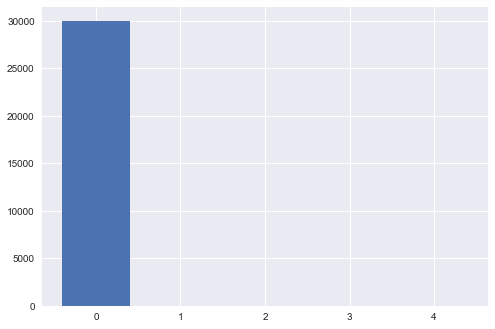

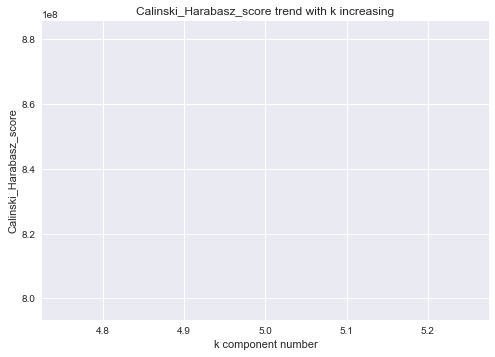

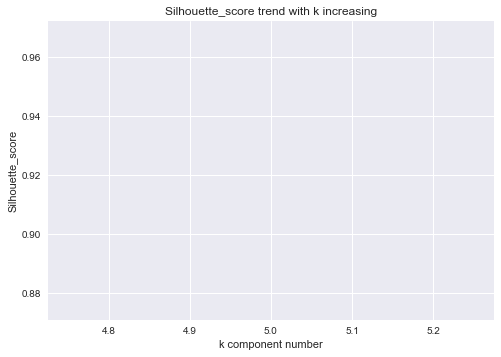

In [10]:
k_list = [5]

select_k_and_display(k_list, user_dis_normalized)